## Lab 3
### Part 1: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, train=True, transform=train_transform, target_transform=None, download=download
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, train=False, transform=test_transform, target_transform=None, download=download
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 232kB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.29MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.03MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                   [-1, 32]          16,416
       BatchNorm1d-6                   [-1, 32]              64
         LeakyReLU-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 418,730
Trainable params: 418,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.60
Estimated Total Size (MB): 1.62
----------------------------------------------------------------


Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-6)
loss_func = nn.CrossEntropyLoss()

epochs_num = 30

for epoch in range(epochs_num):
    train_loss = 0
    train_correct = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        opt.zero_grad()
        output = model(data)
        loss = loss_func(output, target)

        train_loss += loss.item() * data.size(0)

        loss.backward()
        opt.step()

        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)

    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Epoch: {epoch+1}/{epochs_num}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

Epoch: 1/30, Loss: 0.6030, Train Accuracy: 78.62%, Test Accuracy: 82.12%
Epoch: 2/30, Loss: 0.4568, Train Accuracy: 83.27%, Test Accuracy: 85.14%
Epoch: 3/30, Loss: 0.4249, Train Accuracy: 84.38%, Test Accuracy: 85.73%
Epoch: 4/30, Loss: 0.3998, Train Accuracy: 85.14%, Test Accuracy: 86.28%
Epoch: 5/30, Loss: 0.3870, Train Accuracy: 85.76%, Test Accuracy: 86.86%
Epoch: 6/30, Loss: 0.3790, Train Accuracy: 86.03%, Test Accuracy: 87.37%
Epoch: 7/30, Loss: 0.3654, Train Accuracy: 86.33%, Test Accuracy: 86.76%
Epoch: 8/30, Loss: 0.3585, Train Accuracy: 86.65%, Test Accuracy: 86.75%
Epoch: 9/30, Loss: 0.3505, Train Accuracy: 86.97%, Test Accuracy: 87.42%
Epoch: 10/30, Loss: 0.3492, Train Accuracy: 87.04%, Test Accuracy: 87.53%
Epoch: 11/30, Loss: 0.3407, Train Accuracy: 87.37%, Test Accuracy: 87.71%
Epoch: 12/30, Loss: 0.3329, Train Accuracy: 87.58%, Test Accuracy: 88.01%
Epoch: 13/30, Loss: 0.3339, Train Accuracy: 87.46%, Test Accuracy: 88.06%
Epoch: 14/30, Loss: 0.3265, Train Accuracy: 87.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [10]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [11]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                   [-1, 32]          32,800
              ReLU-5                   [-1, 32]               0
            Linear-6                   [-1, 10]             330
Total params: 836,970
Trainable params: 836,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.19
Estimated Total Size (MB): 3.22
----------------------------------------------------------------


In [12]:
import matplotlib.pyplot as plt

def calculate_loss_and_accuracy(model, data_loader, loss_func, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_func(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    return total_loss, accuracy

In [13]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

epochs_num = 50

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs_num):
    train_loss = 0
    train_correct = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        opt.zero_grad()
        output = model(data)
        loss = loss_func(output, target)

        train_loss += loss.item() * data.size(0)

        loss.backward()
        opt.step()

        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()



    train_loss, train_accuracy = calculate_loss_and_accuracy(model, train_loader, loss_func, device)
    test_loss, test_accuracy = calculate_loss_and_accuracy(model, test_loader, loss_func, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch: {epoch+1}/{epochs_num}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch: 1/50, Train Loss: 0.3980, Train Accuracy: 85.50%, Test Loss: 0.4429, Test Accuracy: 83.98%
Epoch: 2/50, Train Loss: 0.3331, Train Accuracy: 87.98%, Test Loss: 0.3873, Test Accuracy: 86.23%
Epoch: 3/50, Train Loss: 0.3079, Train Accuracy: 88.68%, Test Loss: 0.3766, Test Accuracy: 86.47%
Epoch: 4/50, Train Loss: 0.2939, Train Accuracy: 88.91%, Test Loss: 0.3649, Test Accuracy: 86.61%
Epoch: 5/50, Train Loss: 0.2875, Train Accuracy: 89.36%, Test Loss: 0.3734, Test Accuracy: 86.81%
Epoch: 6/50, Train Loss: 0.2603, Train Accuracy: 90.17%, Test Loss: 0.3513, Test Accuracy: 87.19%
Epoch: 7/50, Train Loss: 0.2498, Train Accuracy: 90.61%, Test Loss: 0.3396, Test Accuracy: 88.14%
Epoch: 8/50, Train Loss: 0.2360, Train Accuracy: 91.20%, Test Loss: 0.3324, Test Accuracy: 88.19%
Epoch: 9/50, Train Loss: 0.2494, Train Accuracy: 90.38%, Test Loss: 0.3523, Test Accuracy: 87.65%
Epoch: 10/50, Train Loss: 0.2215, Train Accuracy: 91.76%, Test Loss: 0.3362, Test Accuracy: 88.47%
Epoch: 11/50, Train

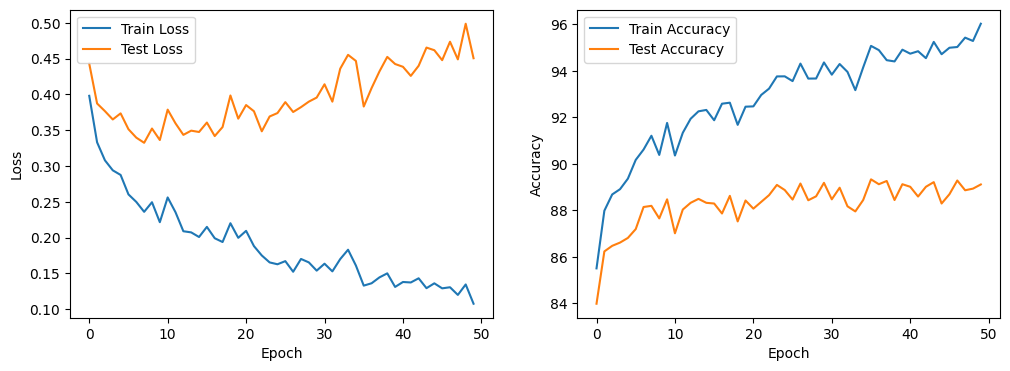

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [15]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 32),
            nn.Dropout(0.25),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
           Dropout-3                 [-1, 1024]               0
              ReLU-4                 [-1, 1024]               0
            Linear-5                   [-1, 32]          32,800
           Dropout-6                   [-1, 32]               0
       BatchNorm1d-7                   [-1, 32]              64
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 10]             330
Total params: 837,034
Trainable params: 837,034
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.19
Estimated Total Size (MB): 3.23
-------------------------------------------

In [17]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

epochs_num = 30

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs_num):
    train_loss = 0
    train_correct = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        opt.zero_grad()
        output = model(data)
        loss = loss_func(output, target)

        train_loss += loss.item() * data.size(0)

        loss.backward()
        opt.step()

        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()


    train_loss, train_accuracy = calculate_loss_and_accuracy(model, train_loader, loss_func, device)
    test_loss, test_accuracy = calculate_loss_and_accuracy(model, test_loader, loss_func, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch: {epoch+1}/{epochs_num}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch: 1/30, Train Loss: 0.4357, Train Accuracy: 84.36%, Test Loss: 0.4746, Test Accuracy: 82.87%
Epoch: 2/30, Train Loss: 0.3846, Train Accuracy: 85.91%, Test Loss: 0.4291, Test Accuracy: 84.51%
Epoch: 3/30, Train Loss: 0.3502, Train Accuracy: 87.14%, Test Loss: 0.3991, Test Accuracy: 85.77%
Epoch: 4/30, Train Loss: 0.3332, Train Accuracy: 87.90%, Test Loss: 0.3821, Test Accuracy: 86.22%
Epoch: 5/30, Train Loss: 0.3170, Train Accuracy: 88.19%, Test Loss: 0.3728, Test Accuracy: 86.48%
Epoch: 6/30, Train Loss: 0.3193, Train Accuracy: 88.03%, Test Loss: 0.3769, Test Accuracy: 86.26%
Epoch: 7/30, Train Loss: 0.3164, Train Accuracy: 88.46%, Test Loss: 0.3784, Test Accuracy: 86.54%
Epoch: 8/30, Train Loss: 0.2920, Train Accuracy: 89.06%, Test Loss: 0.3562, Test Accuracy: 86.99%
Epoch: 9/30, Train Loss: 0.2943, Train Accuracy: 89.15%, Test Loss: 0.3597, Test Accuracy: 87.47%
Epoch: 10/30, Train Loss: 0.2774, Train Accuracy: 89.69%, Test Loss: 0.3460, Test Accuracy: 87.55%
Epoch: 11/30, Train

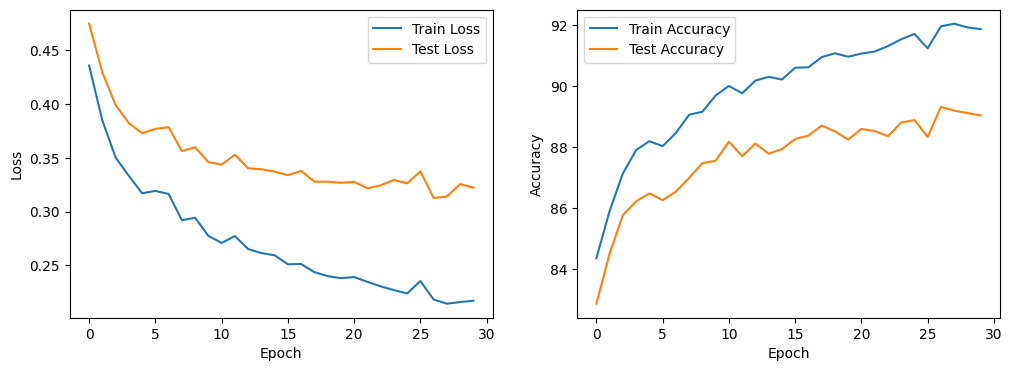

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Conclusions:
Получилось обучить все модели до точности на тестовой выборке более 88.5%, но модель без дропаутов и нормализаций переобучается. На 7-10 эпохе loss на тестовой выборке начинает иметь восходящий тренд, в то время, как на тестовой он продолжает уменьшаться с каждой эпохой. Добавление дропаут- и нормализационных слоев помогает справиться с переобучением.
